# CSE327 Homework 4
**Due date: 11:59 pm on Nov. 30, 2017 (Thursday)**

## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org).

![VGG Model](https://www.cc.gatech.edu/~hays/compvision2016/proj6/deepNetVis.png "VGG_Model")

<center>Figure 1: AlexNet / VGG-F network visualized by [mNeuron](http://vision03.csail.mit.edu/cnn_art/index.html).</center>

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 15-way scene classification. You might have done the spatial pyramid extra credit and gotten up to nearly 80% accuracy. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter code gives you a very simple network architecture which doesn't work that well and you will add jittering, normalization, regularization, and more layers to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 1,500 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network (see Figure 1) which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

## Dataset
---
![Dataset Examples](https://www.cc.gatech.edu/~hays/compvision/proj4/categories.png "Example scenes from of each category in the 15 scene dataset. Figure from Lazebnik et al. 2006.")
You will using the same dataset in homework 3. The dataset contains 100 images from each category (i.e. 1500 training examples total and 1500 test cases total).  Download the dataset [here](https://drive.google.com/a/cs.stonybrook.edu/file/d/0B446EB1iI6_Qc0Q1NTRTajdUVTg/view?usp=sharing).

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

## Starter Code
---
In the starter code, I provide you with a function that load data into minibatches for training and testing in PyTorch.

In [148]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 

import torch
import torchvision #had to install it separately
import torchvision.transforms as transforms

from torch.autograd import Variable #let our network automatically implement back propogation
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

print ('OpenCV version = ' + cv2.__version__)

import torchvision.models as models # to import pre-trained models

import itertools
from sklearn.metrics import confusion_matrix

import time

OpenCV version = 3.3.0


In [149]:
# just something for the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
#     print(cm) # uncomment if you want to print like normal data
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [150]:
# function to just plot both normalizes and normal matrix
def print_confusion_matrix(test_label, predictions):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(test_label, predictions)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [151]:
#function to mirror an image
#takes and input image and flips it horizontally
def img_mirror(img):
    #write code to mirror
    height, width = img.shape
    bi_img = np.zeros((height, width), dtype=np.uint16)
    for i in range(0,height):
        bi_img[i][:] = img [i][::-1]
    return bi_img

In [152]:
def img_L2_norm(img):
    #return np.float32(img) / 255 # normalize img pixels to [0, 1] [-1,1]
    #we can also do the following
    magnitude = np.sqrt(np.sum([(x)**2 for x in img]))
    return np.float32(img)/magnitude
    #return (np.float32(img)/255-0.5)*2

In [153]:
def img_norm(img):
    #return np.float32(img) / 255 # normalize img pixels to [0, 1] [-1,1]
    #we can also do the following
    return (np.float32(img)/255-0.5)*2

In [154]:
#changes the brightness of the image
def img_brightness(img, bright=0):
    height, width = img.shape
    bi_img = np.zeros((height, width), dtype=np.uint16)
    #when it is negative
    if (bright < 0):
        for i in range(0,height): #if the number becomes less than 0, change it to 0 
            bi_img  [i][:] = [( 0 if ((img[i][j] + bright)<0) else (img[i][j] + bright)) for j in range(0,width)]
    else: #when it is positive 
        for i in range(0,height): #if the number becomes more than 255, change it to 255
            bi_img  [i][:] = [( 255 if ((img[i][j] + bright)>=255) else (img[i][j]+ bright)) for j in range(0,width)]      
    return bi_img

In [155]:
# show some images
def imshow(img):
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()

In [156]:
#rotates a given image by a given angle
def img_rotate(img, angle=0):
    rows, cols = img.shape #getting the height and width of the image
    #finding the rotation matrix w.r.t. rotation point being the center of the image
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    warp_img = cv2.warpAffine(img, M, (cols,rows)) #warping the image
    return warp_img

[[159 142 114 ...,  56  49  39]
 [220 234 230 ...,  63  53  46]
 [220 236 238 ...,  67  59  51]
 ..., 
 [ 42  36  37 ...,  31  28  23]
 [ 38  28  38 ...,  26  31  29]
 [ 41  43  45 ...,  31  34  35]]
(200, 267)


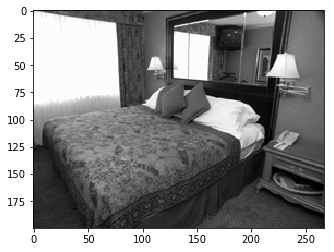

(200, 267)


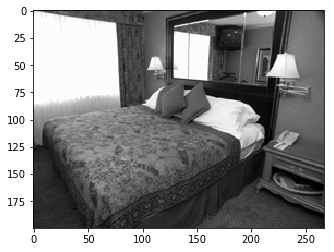

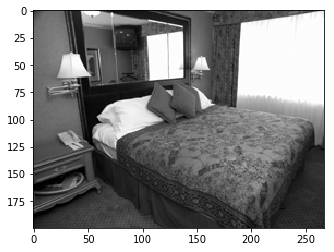

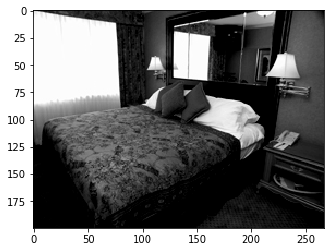

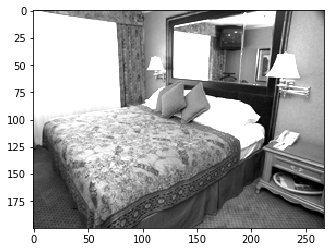

In [157]:
img = cv2.imread('../HW3/data/train/Bedroom/image_0001.jpg', 0)
#just checking if th augmentation is correct
print (img)
print (img.shape)
plt.imshow(img, 'gray')
plt.show()

print (img.shape)
plt.imshow(img_norm(img), 'gray')
plt.show()

img2 = cv2.flip(img,1)
plt.figure()
plt.imshow(img2, 'gray')
plt.show()

img2 = img_brightness(img[:][:], -50)
plt.figure()
plt.imshow(img2, 'gray')
plt.show()

img2 = img_brightness(img, 100)
plt.figure()
plt.imshow(img2, 'gray')
plt.show()

In [196]:
print("I did the normalisation, zero-mean, mirroring and so on but it gave me less accurate results.. so I commented them out")

I did the normalisation, zero-mean, mirroring and so on but it gave me less accurate results.. so I commented them out


In [96]:
# # ==========================================
# #    Load Training Data and Testing Data
# # ==========================================

# class_names = [name[18:] for name in glob.glob('../HW3/data/train/*')]
# class_names = dict(zip(range(len(class_names)), class_names))
# print (class_names) #python2to3modification

# def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False, is_train=True, train_mean = 0):
    
#     data = []
#     labels = []
    
#     if is_color:
#         channel_num = 3
#     else:
#         channel_num = 1
        
#     if (augment):
#         times = 2 #original + mirroring
#         # brighness increase by 100 + brighness decrease by 100
#     else:
#         times = 1
#     # read images and resizing
#     #for id, class_name in class_names.iteritems():  #python2to3modification
#     for id, class_name in class_names.items():
#         img_path_class = glob.glob(path + class_name + '/*.jpg')
#         if num_per_class > 0:
#             img_path_class = img_path_class[:num_per_class]
        
            
#         labels.extend([id]*len(img_path_class)*times) #merging 2 list together #adding the other list to the function
#         for filename in img_path_class:
#             if is_color:
#                 img = cv2.imread(filename)
#             else:
#                 img = cv2.imread(filename, 0)
            
#             # resize the image
#             img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
#             if is_color:
#                 img = np.transpose(img, [2, 0, 1])
            
#             # norm pixel values to [0, 1]
#             data.append(img_norm(img))
            
#             if augment: # data augmentation
#                 data.append(cv2.flip(img,1)) #cv2's implementation for mirroring
#                 #data.append(img_mirror(img)) # my implementation for mirroring
#                 #data.append(img_brightness(img, 100))
#                 #data.append(img_brightness(img, -50))
#                 #data.append(img_rotate(img, 10))
    
#     #doing zero-mean
#     if is_train:
#         mean = img_mean(data)
#         train_mean = mean
#     else:
#         mean = train_mean
        
#     data = [img_L2_norm(item-mean) for item in data]

#     # randomly permute (this step is important for training)
#     if shuffle:
#         #bundle = zip(data, labels)  #python2to3modification
#         bundle = list(zip(data, labels))
#         #bundle = torch.FloatTensor(data, labels)
#         random.shuffle(bundle)
#         #data, labels = torch.FloatTensor(*bundle)
#         data, labels = list(zip(*bundle))  #python2to3modification
    
#     # divide data into minibatches of TorchTensors
#     if batch_num > 1:
#         batch_data = []
#         batch_labels = []
#         for i in range(int(len(data) / batch_num)): #python2to3modification xrange vs range
#             minibatch_d = data[i*batch_num: (i+1)*batch_num]
#             minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
#             batch_data.append(torch.from_numpy(minibatch_d))

#             minibatch_l = labels[i*batch_num: (i+1)*batch_num]
#             batch_labels.append(torch.LongTensor(minibatch_l))
#         data, labels = batch_data, batch_labels 
    
#     if is_train:
#         return list(zip(batch_data, batch_labels)), train_mean
#     else:
#         return list(zip(batch_data, batch_labels))
#     #return zip(batch_data, batch_labels) #python2to3modification

{0: 'Bedroom', 1: 'Coast', 2: 'Forest', 3: 'Highway', 4: 'Industrial', 5: 'InsideCity', 6: 'Kitchen', 7: 'LivingRoom', 8: 'Mountain', 9: 'Office', 10: 'OpenCountry', 11: 'Store', 12: 'Street', 13: 'Suburb', 14: 'TallBuilding'}


In [ ]:
# # load data into size (64, 64)

# img_size = (224, 224)
# batch_num = 50 # training sample number per batch 

# train_mean_global_large = 0.0

# # load training dataset
# trainloader_large, train_mean_global_large = load_dataset('../HW3/data/train/', img_size, batch_num=batch_num, shuffle=False, augment=False, is_color=True, is_train=True, train_mean = 0)
# train_num = len(trainloader_large)
# print ("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# # load testing dataset
# testloader_large = load_dataset('../HW3/data/test/', img_size, num_per_class=100, batch_num=batch_num, shuffle=False, augment=False, is_color=True, is_train=False, train_mean= train_mean_global_large)

# test_num = len(testloader_large)
# print ("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

In [ ]:
# # load data into size (64, 64)

# img_size = (64, 64)
# batch_num = 50 # training sample number per batch 

# train_mean_global_small = 0.0

# # load training dataset
# trainloader_small, train_mean_global_small = load_dataset('../HW3/data/train/', img_size, batch_num=batch_num, shuffle=False, augment=False, is_color=False, is_train=True, train_mean = 0)
# train_num = len(trainloader_small)
# print ("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# # load testing dataset
# testloader_small = load_dataset('../HW3/data/test/', img_size, num_per_class=100, batch_num=batch_num, shuffle=False, augment=False, is_color=False, is_train=False, train_mean= train_mean_global_small)
# test_num = len(testloader_small)
# print ("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

In [160]:
def img_mean(img_arr):
    total = len(img_arr)
    print (total)
    sum_img = np.sum(img_arr, axis=0)
    #sum_img = np.sum(img_arr)
    print (np.float32(sum_img)/total)
    return np.float32(sum_img)/total

In [161]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================

class_names = [name[18:] for name in glob.glob('../HW3/data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print (class_names) #python2to3modification

def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    if (augment):
        times = 2 #original + mirroring
        # brighness increase by 100 + brighness decrease by 100
    else:
        times = 1
    # read images and resizing
    #for id, class_name in class_names.iteritems():  #python2to3modification
    for id, class_name in class_names.items():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        
            
        labels.extend([id]*len(img_path_class)*times) #merging 2 list together #adding the other list to the function
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [0, 1]
            data.append(img_norm(img))
            
            if augment: # data augmentation
                data.append(cv2.flip(img,1)) #cv2's implementation for mirroring
                #data.append(img_mirror(img)) # my implementation for mirroring
                #data.append(img_brightness(img, 100))
                #data.append(img_brightness(img, -50))
                #data.append(img_rotate(img, 10))
            
    # randomly permute (this step is important for training)
    if shuffle:
        #bundle = zip(data, labels)  #python2to3modification
        bundle = list(zip(data, labels))
        #bundle = torch.FloatTensor(data, labels)
        random.shuffle(bundle)
        #data, labels = torch.FloatTensor(*bundle)
        data, labels = list(zip(*bundle))  #python2to3modification
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        for i in range(int(len(data) / batch_num)): #python2to3modification xrange vs range
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return list(zip(batch_data, batch_labels))
    #return zip(batch_data, batch_labels) #python2to3modification

{0: 'Bedroom', 1: 'Coast', 2: 'Forest', 3: 'Highway', 4: 'Industrial', 5: 'InsideCity', 6: 'Kitchen', 7: 'LivingRoom', 8: 'Mountain', 9: 'Office', 10: 'OpenCountry', 11: 'Store', 12: 'Street', 13: 'Suburb', 14: 'TallBuilding'}


In [163]:
# load data into size (64, 64)

img_size = (64, 64)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_small = load_dataset('../HW3/data/train/', img_size, batch_num=batch_num, shuffle=True, augment=False, is_color=False)
train_num = len(trainloader_small)
print ("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = load_dataset('../HW3/data/test/', img_size, num_per_class=100, batch_num=batch_num, shuffle=False, augment=False, is_color=False)
test_num = len(testloader_small)
print ("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Finish loading 30 minibatches(=50) of training samples.
Finish loading 30 minibatches(=50) of testing samples.


Below we visualize one training sample:

Highway


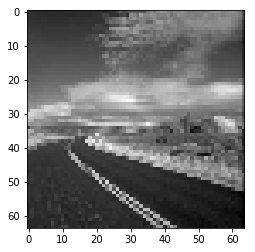

Suburb


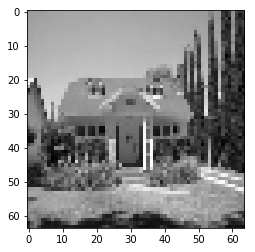

In [164]:
i = 29
img, label = trainloader_small[i][0][11][0], trainloader_small[i][1][11]
img2, label2 = trainloader_small[i][0][10][0], trainloader_small[i][1][10]
print (class_names[label]) #python2to3modification
imshow(img)
print (class_names[label2]) #python2to3modification
imshow(img2)


## Problem 1: Training a Network From Scratch
{50 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 15-way classification accuracy). You first task is to build a simple shallow neural network to do scene classification. Your network will be of the following architecture: Input layer takes in grayscale images are of size 64x64, followed by a convolutional layer of kernel size 9x9, stride 1 and 9 output channels, followed by ReLU and max pooling layer of kernel size 7x7 and stride 7, followed by a fully connected layer. After you do the training and testing, we can now recognize scenes with... around 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process. 

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. Mirroring helps quite a bit on its own, though, and is easy to implement. You should see a roughly 10% increase in accuracy by adding mirroring. 

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 1,500 original training images as much (because it sees 3,000 training images now, although they're not as good as 3,000 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. 

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 10% or so increase in accuracy.

z-score .. make the center 0

**Network Regularization**: Add a dropout layer right before the last fully connected layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the testing error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) you should be able to achieve around 50% test accuracy.

**{Bonus part: 10pts}** Try one or two tricks taught in the class to increase the accuracy of your model. Such as increasing training data by random rotating training images, try different activation functions (e.g., sigmoid) and even modify the architecture of the model. Note that too many layers can do you no good due to insufficient training data.

In [165]:
#question:
        # input layer takes in grayscale images are of size 64x64, 
        # followed by a convolutional layer of kernel size 9x9, stride 1 and 9 output channels, 
        # followed by ReLU and 
        # max pooling layer of kernel size 7x7 and stride 7, 
        # followed by a fully connected layer.
        
class pltNet(nn.Module):

    def __init__(self):
        super(pltNet, self).__init__()
        # dimension of the convolutional layer = (N - F)/stride + 1
        # here N = N of N*N size of input image
        # F = F of F*F square convolution
        # stride being the stride 
        
        # 1 input image channel, 9 output channels, 9x9 square convolution
        self.conv1 = nn.Conv2d(1, 9, 9) # (64-9)/1 + 1 = 55 + 1 = 56 #output = 56*56*9 #9 filters
        # output gives 56*56*9
        self.relu = nn.ReLU() #now RELU #output still 56*56*9
        self.pool = nn.MaxPool2d(7, 7) # max pool of 7*7 of stride 7 # so 56/7 = 8 both in height and width gives:
        # output of 8*8*9
        self.do1 = nn.Dropout(p=0.5) #drops out some nodes
        self.fc1 = nn.Linear(8*8*9, 15) #fully connected layer # 576 -> 15

    def forward(self, x):
        # Max pooling over a (7, 7) window
        #x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size= (7, 7), stride = 7)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.do1(x) #drop out of p =0.5
        x = self.fc1(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

pltnet_small = pltNet()
print(pltnet_small)

pltNet (
  (conv1): Conv2d(1, 9, kernel_size=(9, 9), stride=(1, 1))
  (relu): ReLU ()
  (pool): MaxPool2d (size=(7, 7), stride=(7, 7), dilation=(1, 1))
  (do1): Dropout (p = 0.5)
  (fc1): Linear (576 -> 15)
)


In [166]:
params = list(pltnet_small.parameters())
print (len(params)) 
print (params[0].size())
print ("represents: number of filters, input channel, filter size (m,n)")

4
torch.Size([9, 1, 9, 9])
represents: number of filters, input channel, filter size (m,n)


In [167]:
use_gpu = torch.cuda.is_available()

In [168]:
criterion = nn.CrossEntropyLoss()
optimizer_small = optim.Adam(pltnet_small.parameters(), lr=0.001) #learning rate

In [192]:
s = time.clock()
for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader_small, 0):
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
#         if use_gpu:
#             inputs = Variable(inputs.cuda())
#             labels = Variable(labels.cuda())
#         else:
#             inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer_small.zero_grad()

        pltnet_small.train(True)
        # forward + backward + optimize
        outputs = pltnet_small(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_small.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 30 ==29:    # print every 30 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0
e = time.clock()
print('Finished Training, Time: '+ str(e-s))

[1,    30] loss: 0.652
[2,    30] loss: 0.693
[3,    30] loss: 0.692
[4,    30] loss: 0.719
[5,    30] loss: 0.680
[6,    30] loss: 0.700
[7,    30] loss: 0.669
[8,    30] loss: 0.715
[9,    30] loss: 0.706
[10,    30] loss: 0.718
[11,    30] loss: 0.697
[12,    30] loss: 0.695
[13,    30] loss: 0.685
[14,    30] loss: 0.687
[15,    30] loss: 0.681
[16,    30] loss: 0.680
[17,    30] loss: 0.725
[18,    30] loss: 0.709
[19,    30] loss: 0.709
[20,    30] loss: 0.683
[21,    30] loss: 0.653
[22,    30] loss: 0.715
[23,    30] loss: 0.717
[24,    30] loss: 0.663
[25,    30] loss: 0.714
[26,    30] loss: 0.703
[27,    30] loss: 0.764
[28,    30] loss: 0.707
[29,    30] loss: 0.702
[30,    30] loss: 0.707
[31,    30] loss: 0.695
[32,    30] loss: 0.660
[33,    30] loss: 0.694
[34,    30] loss: 0.698
[35,    30] loss: 0.691
[36,    30] loss: 0.694
[37,    30] loss: 0.680
[38,    30] loss: 0.672
[39,    30] loss: 0.699
[40,    30] loss: 0.705
Finished Training, Time: 193.40341280303255


In [ ]:
print ("I did about 160 epochs.")

In [193]:
correct = 0
total = 0
class_correct = list(0. for i in range(15))
class_total = list(0. for i in range(15))
actual_labels = []
predicted_labels = []

for data in testloader_small:
    images, labels = data
    pltnet_small.train(False)
    outputs = pltnet_small(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
    actual_labels.append(labels)
    predicted_labels.append(predicted)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

for i in range(15):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 57 %
Accuracy of Bedroom : 62 %
Accuracy of Coast : 87 %
Accuracy of Forest : 75 %
Accuracy of Highway : 37 %
Accuracy of Industrial : 25 %
Accuracy of InsideCity : 62 %
Accuracy of Kitchen : 12 %
Accuracy of LivingRoom : 25 %
Accuracy of Mountain : 75 %
Accuracy of Office : 75 %
Accuracy of OpenCountry : 37 %
Accuracy of Store : 75 %
Accuracy of Street : 100 %
Accuracy of Suburb : 25 %
Accuracy of TallBuilding : 75 %


In [194]:
#print ((np.array(train_labels))) #.reshape(-1))
pred_labels = []
for item in predicted_labels:
    for i in item:
        pred_labels.append(i)
act_labels = []
for item in actual_labels:
    for i in item:
        act_labels.append(i)

{0: 'Bedroom', 1: 'Coast', 2: 'Forest', 3: 'Highway', 4: 'Industrial', 5: 'InsideCity', 6: 'Kitchen', 7: 'LivingRoom', 8: 'Mountain', 9: 'Office', 10: 'OpenCountry', 11: 'Store', 12: 'Street', 13: 'Suburb', 14: 'TallBuilding'}


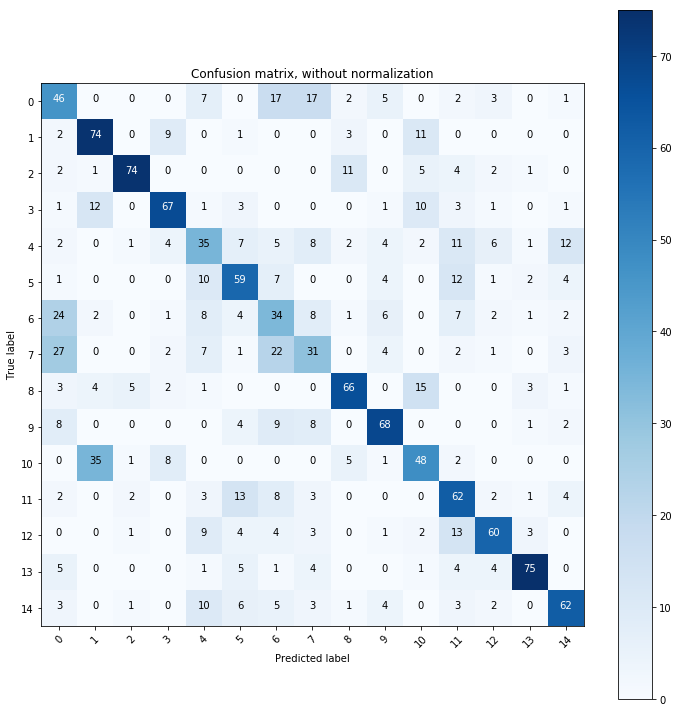

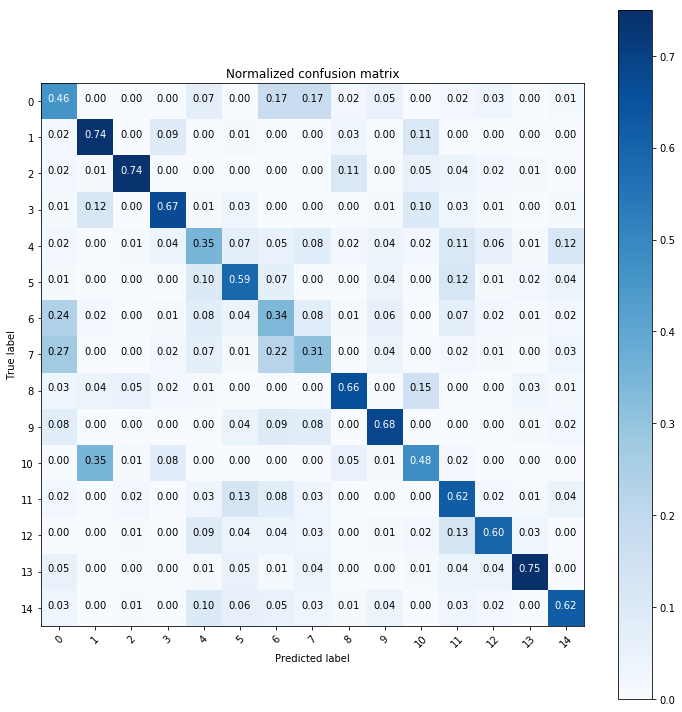

In [195]:
print (class_names)
print_confusion_matrix(act_labels, pred_labels)

## Problem 2: Fine Tuning a Pre-Trained Deep Network
{50 points} Our convolutional network to this point isn't "deep". It has two layers with learned weights. Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take, for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories. **Strategy A**: One could use those 1000 activation as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

Alternatively, **Strategy B** is to *fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 15 scene database) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement Strategy B to fine-tune a pre-trained AlexNet for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

**{Bonus part: 15pts}** Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. 

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).
- You could also try pre-trained models other than AlexNet, VGG-16 for example, as long as there is enough memory in your computer (not mine!).
- Please resize all images to size 224x224 to use AlexNet or VGG.

In [124]:
alexnet = models.alexnet(pretrained=True)

In [125]:
print (alexnet)

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)


In [126]:
def get_new_classifier(classifier, position, input_number, output_number):
    temp_clas = list(classifier)
    temp_clas[position] = nn.Linear(input_number, output_number)
    temp_clas = nn.Sequential(*temp_clas)
    return temp_clas
    

In [127]:
print("Old")
print (alexnet.classifier)
alexnet.classifier = get_new_classifier(alexnet.classifier, 6, 4096, 15)
print ("New")
print (alexnet.classifier)

Sequential (
  (0): Dropout (p = 0.5)
  (1): Linear (9216 -> 4096)
  (2): ReLU (inplace)
  (3): Dropout (p = 0.5)
  (4): Linear (4096 -> 4096)
  (5): ReLU (inplace)
  (6): Linear (4096 -> 1000)
)
Sequential (
  (0): Dropout (p = 0.5)
  (1): Linear (9216 -> 4096)
  (2): ReLU (inplace)
  (3): Dropout (p = 0.5)
  (4): Linear (4096 -> 4096)
  (5): ReLU (inplace)
  (6): Linear (4096 -> 15)
)


In [135]:
criterion = nn.CrossEntropyLoss()
optimizer_large = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)
#optimizer_large = optim.Adam(alexnet.parameters(), lr=0.001)

In [140]:
s = time.clock()
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader_large, 0):
        # get the inputs
        #print (i)
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
#         if use_gpu:
#             inputs = Variable(inputs.cuda())
#             labels = Variable(labels.cuda())
#         else:
#             inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer_large.zero_grad()

        # forward + backward + optimize
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_large.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 30 ==29:    # print every 30 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0
e = time.clock()
print('Finished Training, Time: '+ str(e-s))

[1,    30] loss: 2.730
[2,    30] loss: 2.729
[3,    30] loss: 2.728
[4,    30] loss: 2.727
[5,    30] loss: 2.726
Finished Training, Time: 1832.8613372100772


In [141]:
correct = 0
total = 0
class_correct = list(0. for i in range(15))
class_total = list(0. for i in range(15))
actual_labels = []
predicted_labels = []
for data in trainloader_large:
    images, labels = data
    outputs = alexnet(Variable(images))
    #print (torch.max(outputs.data, 1))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    actual_labels.append(labels)
    predicted_labels.append(predicted)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


for i in range(15):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 6 %
Accuracy of Bedroom :  0 %
Accuracy of Coast : 12 %
Accuracy of Forest :  0 %
Accuracy of Highway :  0 %
Accuracy of Industrial : 75 %
Accuracy of InsideCity :  0 %
Accuracy of Kitchen :  0 %
Accuracy of LivingRoom :  0 %
Accuracy of Mountain :  0 %
Accuracy of Office :  0 %
Accuracy of OpenCountry :  0 %
Accuracy of Store :  0 %
Accuracy of Street :  0 %
Accuracy of Suburb :  0 %
Accuracy of TallBuilding :  0 %


In [30]:
#print ((np.array(train_labels))) #.reshape(-1))
pred_labels = []
for item in predicted_labels:
    for i in item:
        pred_labels.append(i)
act_labels = []
for item in actual_labels:
    for i in item:
        act_labels.append(i)

{0: 'Bedroom', 1: 'Coast', 2: 'Forest', 3: 'Highway', 4: 'Industrial', 5: 'InsideCity', 6: 'Kitchen', 7: 'LivingRoom', 8: 'Mountain', 9: 'Office', 10: 'OpenCountry', 11: 'Store', 12: 'Street', 13: 'Suburb', 14: 'TallBuilding'}


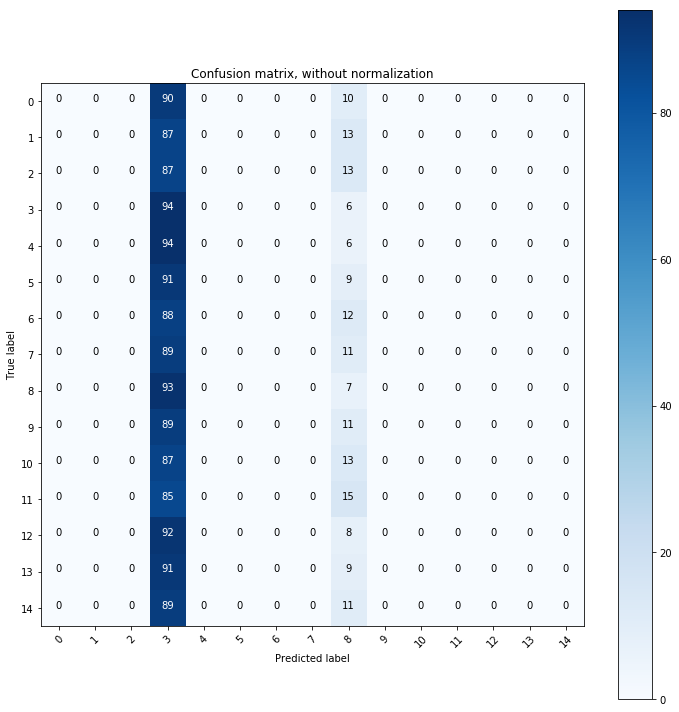

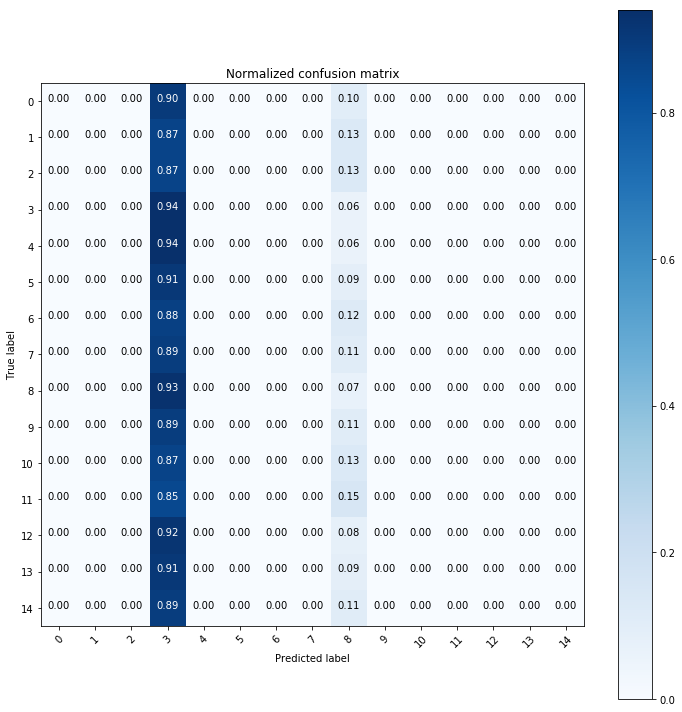

In [31]:
print (class_names)
print_confusion_matrix(act_labels, pred_labels)